# Structure Discovery based on Cliques

Updated on 2020-02-26

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from cliques_discovery import *
from helpers import *

## Overview

The goal of the method is to find a control flow graph (see Allen, 1970, "Control Flow Analysis") that partially describes the process behind a set of logs, i.e., a collection of sequence of events. The method is based on a constructive approach adding examples in which:

```
(For each trace)
1. Calculate all successors only for this trace
2. Build the associated unentangled DAG and remove the loops
3. Combine with previous unentangled DAGs
4. Minimize all DAGs and recover loops info
```

And at the end, once all the examples has been used the information of the loops are ingested back to the resulting graph.

## Method for control flow discovery using cliques

Sketch of the method

In [4]:
# Be a "trace" a sequence over a finite alphabet A
# Be T a collection of traces on A
def cliques_discovery(T):
    
    DAG_allTraces = None # Void graph
    all_loops = {}       # No sequences
    
    for trace in T:

        # --------------------------------------------
        # (1) Calculate the successors (u,v_0), (u, v_1) ...  only for this trace, 
        # --------------------------------------------        
        # (1.1) Get successors and count its frequency
        succ_f = get_successor_by_freq([trace])

        # (1.2) Create the graph of successors, with edges weighted with its frequency (u, v, freq)
        succ_G = successorsGraph( succ_f )

        # --------------------------------------------
        # (2) Build the associated unentangled DAG and remove the loops
        # --------------------------------------------
        # (2.1) using cliques, detect all longest single paths [u_0, u_1, ..., u_m]
        paths_this_trace = infer_paths( split_in_freqGraphs(  succ_G  ) )

        # (2.2) Detect and remove loops (saving for later) by computing raw paths that behaves as loops and return associated DAG.
        loops_this_trace, succ_DAG = remove_loops_in_trace(paths_this_trace, succ_G)
        
        # (2.3) Add loops found in this pair to the loops in all traces
        all_loops = remember_loops( loops_this_trace, all_loops )
        
        # (2.4) Unentanglement. The graph should be now 1-cycle free. So, let's remove any parasite 1-cycle (u,v) (v,u) still in succ_DAG!
        succ_DAG_unentangled = unentangled_DAG( succ_DAG )
        
        # --------------------------------------------
        # (3) Combine with previous unentangled DAGs
        # --------------------------------------------
        DAG_allTraces = combine_DAGs(succ_DAG_unentangled, DAG_allTraces)

    # --------------------------------------------
    # (4) Minimize all DAGs and recover loops info
    # --------------------------------------------

    # (4.1) Extract single paths using cliques. Note that this is the same than step (2.1)
    single_paths = infer_paths( split_in_freqGraphs( DAG_allTraces ) )
    
    # (4.2) Build the graph of paths and minimize it: if paths (u,z,v) and (u,v) exists, leave just (u,z,v)
    G = minimally_connected( path_graph( single_paths ) )
    
    # (4.3) Recover loops info , perhaps based on some threshold...
    # PENDING!!
    
    return single_paths, all_loops, G


## Results

### Simple examples

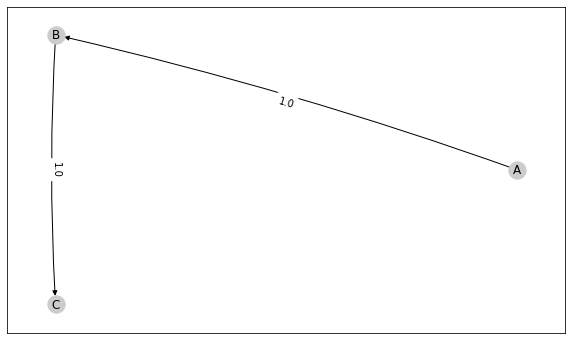

Paths: 
 {1.0: [['A', 'B', 'C']]}
Loops: 
 {}


In [5]:
# Single path ABC
T = [list("ABC")]
pretty ( cliques_discovery(T) )

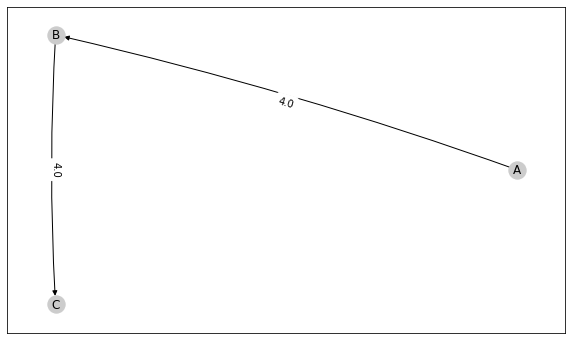

Paths: 
 {4.0: [['A', 'B', 'C']]}
Loops: 
 {('A', 'B', 'C'): 4.0}
CPU times: user 585 ms, sys: 64.7 ms, total: 650 ms
Wall time: 272 ms


In [6]:
# Loop ABC
T = [list("ABCABCABCABC")]
%time pretty ( cliques_discovery(T) )

### Combined single paths and loops

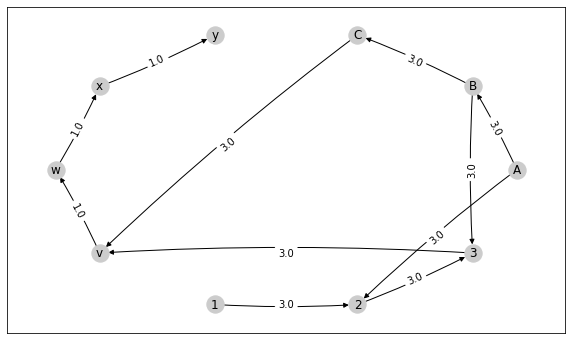

Paths: 
 {1.0: [['v', 'w', 'x', 'y']], 3.0: [['A', 'B', 'C', 'y'], ['A', 'B', 'C', 'x'], ['A', 'B', 'C', 'w'], ['A', 'B', 'C', 'v'], ['1', '2', '3', 'y'], ['1', '2', '3', 'x'], ['1', '2', '3', 'w'], ['1', '2', '3', 'v'], ['A', '2', '3', 'y'], ['A', '2', '3', 'x'], ['A', '2', '3', 'w'], ['A', '2', '3', 'v'], ['A', 'B', '3', 'y'], ['A', 'B', '3', 'x'], ['A', 'B', '3', 'w'], ['A', 'B', '3', 'v']]}
Loops: 
 {('1', '2', '3'): 3.0, ('A', 'B', '3'): 3.0, ('A', '2', '3'): 3.0, ('A', 'B', 'C'): 3.0}
CPU times: user 640 ms, sys: 61.1 ms, total: 701 ms
Wall time: 321 ms


In [7]:
# Loops: "ABC", "123", s-path: "vwxy"
T = [list("ABC1231A2B3C1ABC23vwxy")]
%time pretty ( cliques_discovery(T) )

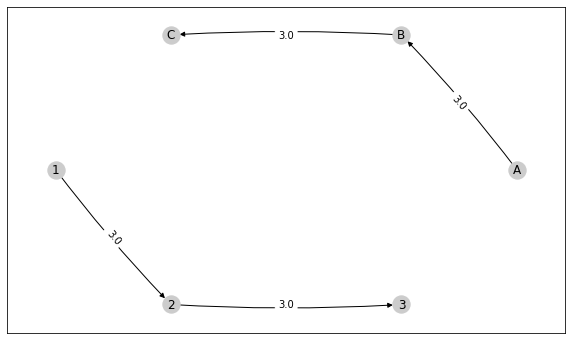

Paths: 
 {3.0: [['A', 'B', 'C'], ['1', '2', '3']]}
Loops: 
 {('A', 'B', 'C'): 3.0, ('1', '2', '3'): 3.0}
CPU times: user 594 ms, sys: 60.5 ms, total: 655 ms
Wall time: 273 ms


In [8]:
#  Loops ABC, 123
T = [
    list(".1A.B2.C3..ABC...A1..2B..3C.123")
]
%time pretty ( cliques_discovery(T) )

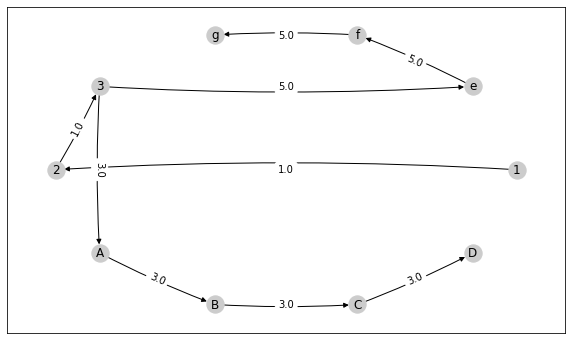

Paths: 
 {1.0: [['1', '2', '3']], 3.0: [['1', 'A', 'B', 'C', 'D'], ['3', 'A', 'B', 'C', 'D'], ['2', 'A', 'B', 'C', 'D']], 5.0: [['1', 'e', 'f', 'g'], ['3', 'e', 'f', 'g'], ['2', 'e', 'f', 'g']]}
Loops: 
 {('A', 'B', 'C', 'D'): 3.0, ('e', 'f', 'g'): 5.0}
CPU times: user 625 ms, sys: 64.1 ms, total: 689 ms
Wall time: 306 ms


In [9]:
"""
head_with_loop = 123 ABCD* efg*

12 @ABCD @ef
"""
T = [
    list("123ABCDefgABCDABCDefgefgefgefg")
]
%time pretty ( cliques_discovery(T) )

### Multiple Traces

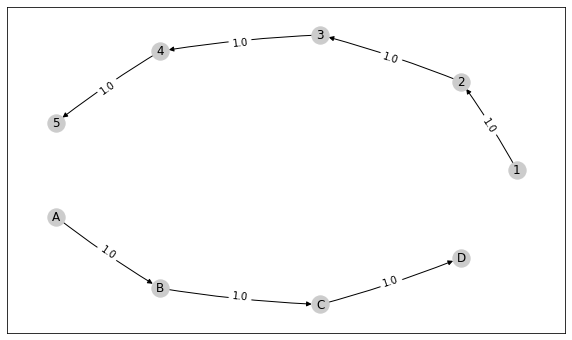

Paths: 
 {1.0: [['1', '2', '3', '4', '5'], ['A', 'B', 'C', 'D']]}
Loops: 
 {}
CPU times: user 605 ms, sys: 64.7 ms, total: 669 ms
Wall time: 285 ms


In [10]:
T = [
    list("ABCD"),
    list("12345")
]
%time pretty ( cliques_discovery(T) )

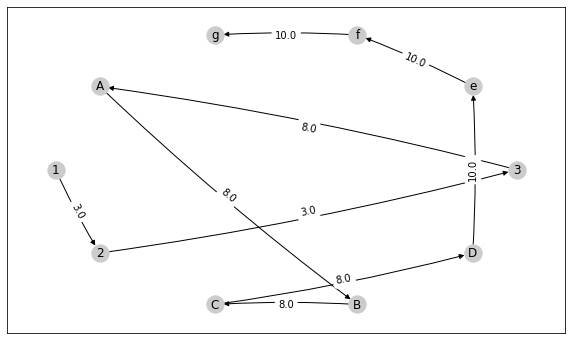

Paths: 
 {8.0: [['1', 'A', 'B', 'C', 'D'], ['3', 'A', 'B', 'C', 'D'], ['2', 'A', 'B', 'C', 'D']], 10.0: [['3', 'e', 'f', 'g'], ['A', 'e', 'f', 'g'], ['1', 'e', 'f', 'g'], ['2', 'e', 'f', 'g'], ['C', 'e', 'f', 'g'], ['B', 'e', 'f', 'g'], ['D', 'e', 'f', 'g']], 3.0: [['1', '2', '3']]}
Loops: 
 {('A', 'B', 'C', 'D'): 8.0, ('e', 'f', 'g'): 10.0}
CPU times: user 680 ms, sys: 58.9 ms, total: 739 ms
Wall time: 360 ms


In [11]:
"""
head_with_loop = 123 ABCD* efg*

12 @ABCD @ef
"""
T = [
    list("123ABCDefgABCDABCDefgefgefgefg"),
    list("123ABCDABCDefgefgefgefgefg"),
    list("123ABCDABCDABCD")
]
%time pretty ( cliques_discovery(T) )

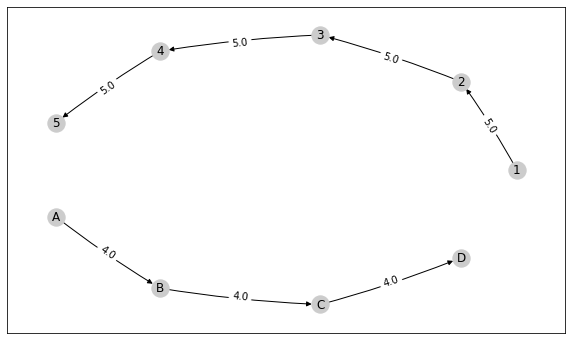

Paths: 
 {4.0: [['A', 'B', 'C', 'D']], 5.0: [['1', '2', '3', '4', '5']]}
Loops: 
 {('A', 'B', 'C', 'D'): 2.0, ('A', 'B', 'C', 'D', '1', '2', '3', '4', '5'): 2.0, ('1', '2', '3', '4', '5'): 3.0}
CPU times: user 627 ms, sys: 61.4 ms, total: 688 ms
Wall time: 312 ms


In [12]:
T = [
    list("ABCDABCD"),
    list("ABCD12345ABCD12345"),
    list("123451234512345")
]
%time pretty ( cliques_discovery(T) )

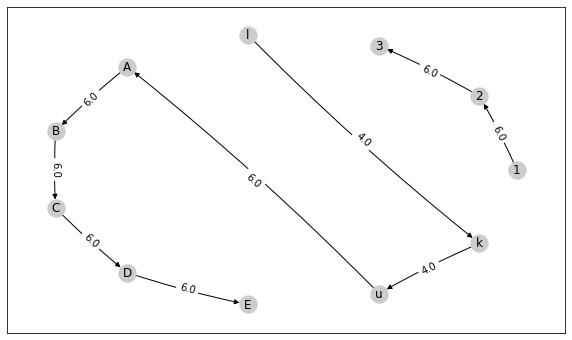

Paths: 
 {4.0: [['l', 'k', 'u']], 6.0: [['1', '2', '3'], ['l', 'A', 'B', 'C', 'D', 'E'], ['u', 'A', 'B', 'C', 'D', 'E'], ['k', 'A', 'B', 'C', 'D', 'E']]}
Loops: 
 {('l', 'k', 'u'): 2.0, ('A', 'B', 'C', 'D', 'E'): 5.0, ('l', 'A', 'B', 'C', 'D', 'E'): 3.0, ('u', 'A', 'B', 'C', 'D', 'E'): 3.0, ('k', 'A', 'B', 'C', 'D', 'E'): 3.0, ('1', '2', '3'): 4.0}
CPU times: user 658 ms, sys: 59.8 ms, total: 717 ms
Wall time: 339 ms


In [13]:
# combined_loops: lk 12 ABCDE
T = [
    list("lkulku123123ABCDEABCDEABCDE123123"),
    list("lku123ABCDEABCDE"),
    list("lku123ABCDE"),
]
%time pretty ( cliques_discovery(T) )

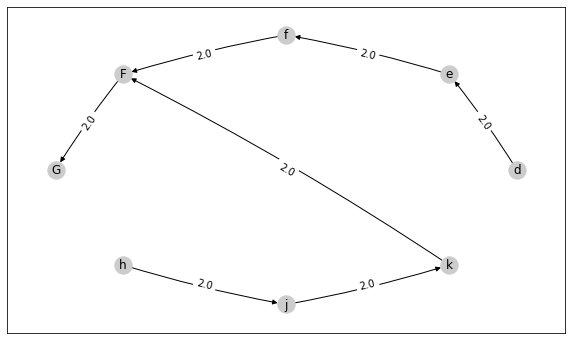

Paths: 
 {2.0: [['d', 'e', 'f', 'F', 'G'], ['h', 'j', 'k', 'F', 'G']]}
Loops: 
 {('d', 'e', 'f'): 2.0, ('h', 'j', 'k'): 2.0}
CPU times: user 623 ms, sys: 63.7 ms, total: 687 ms
Wall time: 309 ms


In [14]:
"""
  @def 
       > FG 
  @hjk 
"""        
T = [
    list("defdefFG"),
    list("hjkhjkFG")
]
%time pretty ( cliques_discovery(T) )

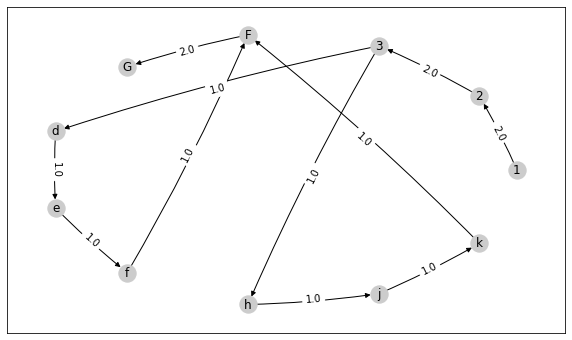

Paths: 
 {1.0: [['3', 'd', 'e', 'f'], ['1', 'd', 'e', 'f'], ['2', 'd', 'e', 'f'], ['d', 'e', 'f', 'F'], ['d', 'e', 'f', 'G'], ['3', 'h', 'j', 'k'], ['1', 'h', 'j', 'k'], ['2', 'h', 'j', 'k'], ['h', 'j', 'k', 'F'], ['h', 'j', 'k', 'G']], 2.0: [['1', '2', '3', 'F', 'G']]}
Loops: 
 {}
CPU times: user 655 ms, sys: 64.1 ms, total: 719 ms
Wall time: 340 ms


In [15]:
"""
        hjk
  123 <     > FG
        def 
"""
T = [
    list("123defFG"),
    list("123hjkFG")
]
%time pretty ( cliques_discovery(T) )

### Interleaved

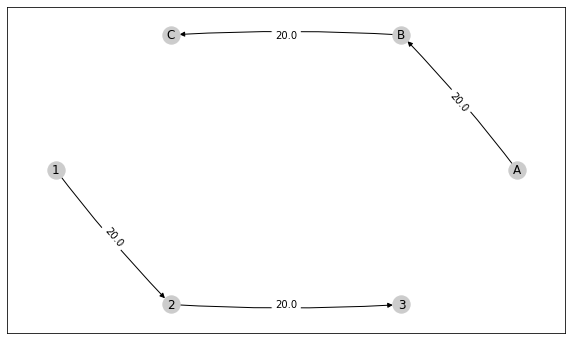

Paths: 
 {20.0: [['A', 'B', 'C'], ['1', '2', '3']]}
Loops: 
 {}
CPU times: user 599 ms, sys: 60.8 ms, total: 659 ms
Wall time: 275 ms


In [16]:
"""
   ABC * 123        
"""
T = [ list(a) for a in ['ABC123', 'AB1C23', 'AB12C3', 'AB123C', 'A1BC23', 'A1B2C3', 'A1B23C', 
      'A12BC3', 'A12B3C', 'A123BC', '1ABC23', '1AB2C3', '1AB23C', '1A2BC3', 
      '1A2B3C', '1A23BC', '12ABC3', '12AB3C', '12A3BC', '123ABC'
]]
%time pretty ( cliques_discovery(T) )

### Some problems below... 2020-02-26

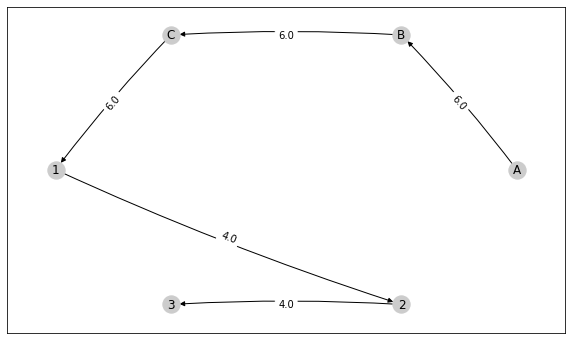

Paths: 
 {4.0: [['1', '2', '3']], 6.0: [['A', 'B', 'C', '1'], ['A', 'B', 'C', '3'], ['A', 'B', 'C', '2']]}
Loops: 
 {('1', '2', '3'): 4.0, ('A', 'B', 'C'): 6.0, ('1', 'A', 'B', 'C'): 3.0, ('3', 'A', 'B', 'C'): 3.0, ('2', 'A', 'B', 'C'): 3.0}
CPU times: user 621 ms, sys: 63.3 ms, total: 685 ms
Wall time: 303 ms


In [17]:
T = [
    list("123123ABCABCABC"),
    list("ABCABCABC123123")
]
%time pretty ( cliques_discovery(T) )

In [37]:
from datetime import datetime
for N in [100,200, 300, 400, 500]:
    T = [ list("123123ABCABCABC"*N) ]
    cliques_discovery(T)
    now = datetime.now()
    display( now.strftime("%d/%m/%Y %H:%M:%S") )
    
     

'30/04/2020 18:07:52'

'30/04/2020 18:07:55'

'30/04/2020 18:08:03'

'30/04/2020 18:08:17'

'30/04/2020 18:08:39'

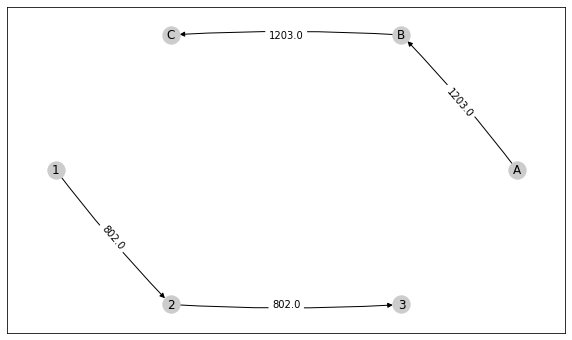

Paths: 
 {802.0: [['1', '2', '3']], 1203.0: [['A', 'B', 'C']]}
Loops: 
 {('A', 'B', 'C'): 1203.0, ('1', '2', '3'): 802.0}
CPU times: user 13.2 s, sys: 839 ms, total: 14 s
Wall time: 13.7 s


In [41]:
T = [
    list("123123ABCABCABC" * 400),
    list("ABCABCABC123123" * 1)
]
%time pretty ( cliques_discovery(T) )

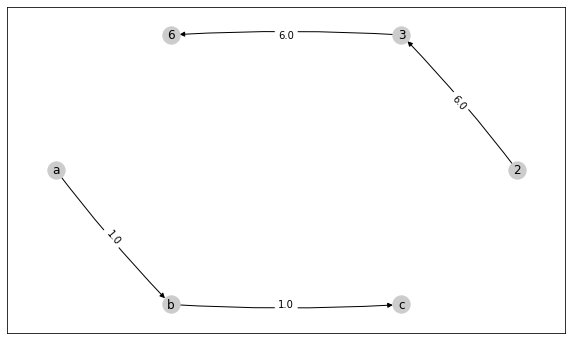

Paths: 
 {1.0: [['a', 'b', 'c']], 6.0: [['2', '3', '6']]}
Loops: 
 {('2', '3', '6'): 6.0}
CPU times: user 577 ms, sys: 64.5 ms, total: 642 ms
Wall time: 297 ms


In [52]:
T = [
    list("12345612316"),
    list("12345612316"),
    list("12345612316"),
    list("abc")
]
%time pretty ( cliques_discovery(T) )

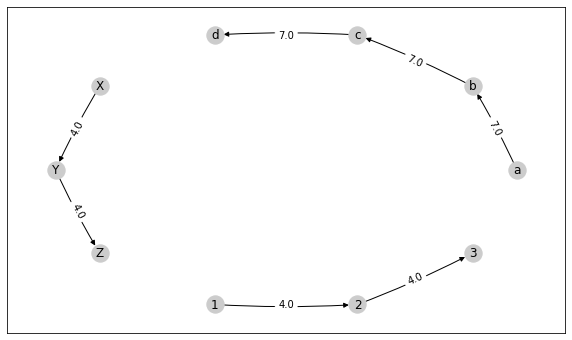

Paths: 
 {4.0: [['X', 'Y', 'Z'], ['1', '2', '3']], 7.0: [['a', 'b', 'c', 'd']]}
Loops: 
 {('1', '2', '3'): 4.0, ('X', 'Y', 'Z'): 4.0, ('a', 'b', 'c', 'd'): 7.0}
CPU times: user 635 ms, sys: 64.8 ms, total: 700 ms
Wall time: 321 ms


In [59]:
T = [
    list("aXYbZcd1X2YZ3ab1XYcd2Zab3cdXYaZbc123dabcd1a2bc3dabcd"),
]
%time pretty ( cliques_discovery(T) )